In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
file_path = "/content/drive/MyDrive/FP_Wantao/VisionEngine-master"

In [3]:
import os
os.chdir(file_path)

In [4]:
import sys
ROOT_DIR=os.path.abspath(file_path)
sys.path.append(ROOT_DIR)

In [5]:
cd /content/drive/MyDrive/FP_Wantao/VisionEngine-master/VisionEngine

/content/drive/MyDrive/FP_Wantao/VisionEngine-master/VisionEngine


In [6]:
!pip install visionengine
!pip install dotmap
!pip install python-dotenv
!pip install openTSNE
!pip install tensorflow==2.2.0
!pip install --upgrade tbb

In [7]:
from VisionEngine.utils.config import process_config
from VisionEngine.utils import factory
from VisionEngine.utils import plotting
from VisionEngine.utils.eval import (embed_images, 
                                     reconstruct_images,
                                     reconstruct_images, 
                                     sample_likelihood)

from VisionEngine.utils.plotting import imscatter

from VisionEngine.utils.perceptual_loss import (make_perceptual_loss_model,
                                                calculate_perceptual_distances)

from VisionEngine.utils.disentanglement_score import dissentanglement_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import os
from dotenv import load_dotenv
from pathlib import Path

import numpy as np
import tensorflow as tf

from openTSNE import TSNE
#from openTSNE.callbacks import ErrorLogger

import matplotlib.pyplot as plt
import matplotlib as mpl

In [8]:
# If you only have one GPU, this must = 0
GPU = 0

In [9]:
env_path = Path('../') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [10]:
# DHRL-Trained Guppies (Original Data)
checkpoint_path = os.path.join(
    ROOT_DIR,
    "checkpoints/guppy_DHRL/2022-058-23/guppy_DHRL_blood_batchsize16.hdf5"
)
config_file = os.path.join(
    ROOT_DIR,
    "VisionEngine/configs/guppies_DHRL_config.json"
)

In [11]:
config = process_config(config_file)
# need to change a few config values
config.data_loader.shuffle = False
config.data_loader.use_generated = False
config.data_loader.use_real = True

In [12]:
with tf.device(f'/device:GPU:{GPU}'):
    model = factory.create(
                "VisionEngine.models."+config.model.name
                )(config)

importing VisionEngine.models.model
getattr VLAEModel
Model: "vlae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
noise_layer (Sequential)        (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
encoder (Model)                 [(None, 524288), (No 38380171    noise_layer[0][0]                
__________________________________________________________________________________________________
variational_layer (VariationalL (None, 10)           5242890     encoder[1][0]                    
_________________________________________

In [13]:
model.load(checkpoint_path)
model.trainable = False

Loading model checkpoint /content/drive/MyDrive/FP_Wantao/VisionEngine-master/checkpoints/guppy_DHRL/2022-058-23/guppy_DHRL_blood_batchsize16.hdf5 ...

Model loaded


In [14]:
data_loader = factory.create(
            "VisionEngine.data_loaders."+config.data_loader.name
            )(config)

importing VisionEngine.data_loaders.data_loader
getattr DataLoader
Using cached dataset


In [15]:
with tf.device(f'/device:GPU:{GPU}'):
    z = embed_images(data_loader.get_test_data(), model)
    lh = sample_likelihood(data_loader.get_test_data(), model)
    lh = (lh-tf.math.reduce_mean(lh))/tf.math.reduce_std(lh)
    images_ = iter(data_loader.get_test_data())
    images =  np.stack([image[0].numpy() for image in data_loader.get_plot_data()])
    images = images.reshape(len(images),256*256*4)

**Visualize Reconstructions**

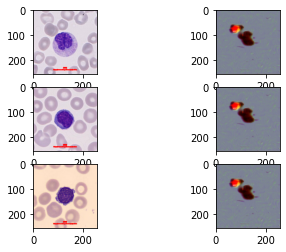

In [16]:
with tf.device(f'/device:GPU:{GPU}'):
    images_hat = images_.next()[0]
    x_hat = reconstruct_images(images_hat,model)
    ID = 2
    plt.subplot(321)
    plt.imshow(plotting.plot_im(images_hat[ID],config))
    plt.subplot(322)
    plt.imshow(plotting.plot_im(x_hat[ID],config))
    images_hat = images_.next()[0]
    x_hat = reconstruct_images(images_hat,model)
    ID = 2
    plt.subplot(323)
    plt.imshow(plotting.plot_im(images_hat[ID],config))
    plt.subplot(324)
    plt.imshow(plotting.plot_im(x_hat[ID],config))
    images_hat = images_.next()[0]
    x_hat = reconstruct_images(images_hat,model)
    ID = 2
    plt.subplot(325)
    plt.imshow(plotting.plot_im(images_hat[ID],config))
    plt.subplot(326)
    plt.imshow(plotting.plot_im(x_hat[ID],config))

**Visualize Sample Likelihood**

In [17]:
perception = []
with tf.device('/device:cpu:0'):
    perceptual_model = make_perceptual_loss_model((256,256,3))
    for batch in data_loader.get_test_data():
        perception.extend(perceptual_model.predict(batch))
    perceptual_distances = calculate_perceptual_distances(np.array(perception))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Visualize Perceptual Distance, Raw Pixel, and Our Approach**

In [18]:
perceptual_embedding = TSNE(
    #callbacks=ErrorLogger(),  
    n_jobs=8).fit(perceptual_distances.T)
raw_image_embedding = TSNE(
    #callbacks=ErrorLogger(), 
    exaggeration=4, learning_rate=len(z)/12, n_jobs=8).fit(images)
vision_engine_embedding = TSNE(
    #callbacks=ErrorLogger(), 
    n_jobs=8).fit(np.concatenate([z[0],z[1],z[2],z[3]], axis=1))
h1 = TSNE(
    #callbacks=ErrorLogger(), 
    n_jobs=8).fit(z[0])
h2 = TSNE(
    #callbacks=ErrorLogger(),  
    n_jobs=8).fit(z[1])
h3 = TSNE(
    #callbacks=ErrorLogger(),
    n_jobs=8).fit(z[2])
h4 = TSNE(
    #callbacks=ErrorLogger(),  
    n_jobs=8).fit(z[3])

In [19]:
with tf.device(f'/device:GPU:{GPU}'):
    labels = []
    images = []
    for image, label in data_loader.get_plot_data():
        labels.append(label.numpy().decode('utf8'))
        images.append(image.numpy().astype('uint8'))
    images = np.stack(images)
    labels = np.array(labels)

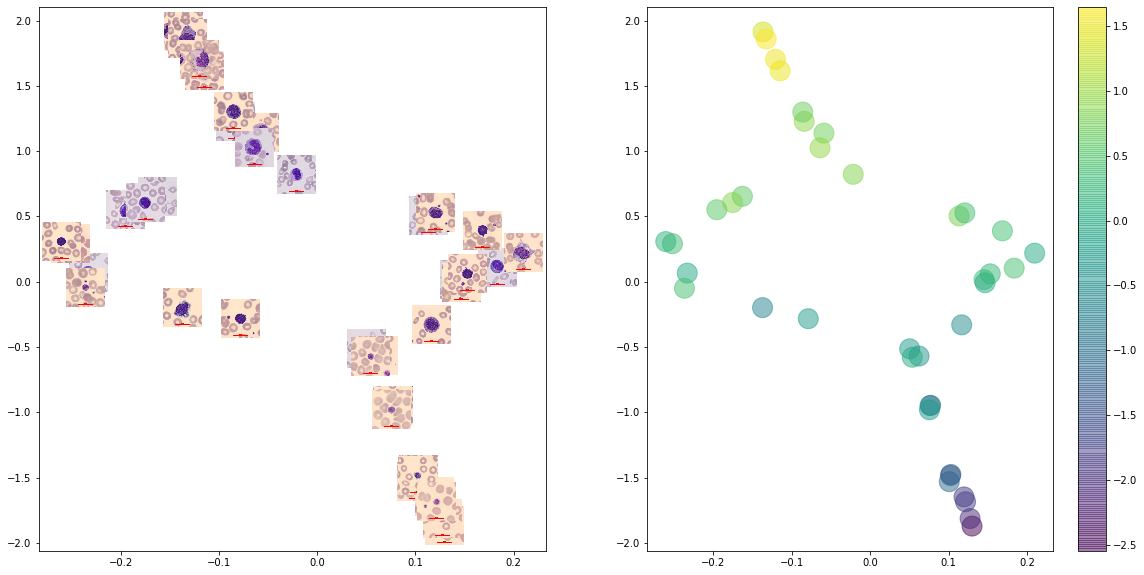

In [20]:
plt.figure(figsize=(20,10))

cmap = plt.cm.viridis

embedding = vision_engine_embedding
plt.subplot(121)
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.15);

plt.subplot(122)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5,
        c=lh, cmap=cmap, s=400, rasterized=True)

plt.colorbar()

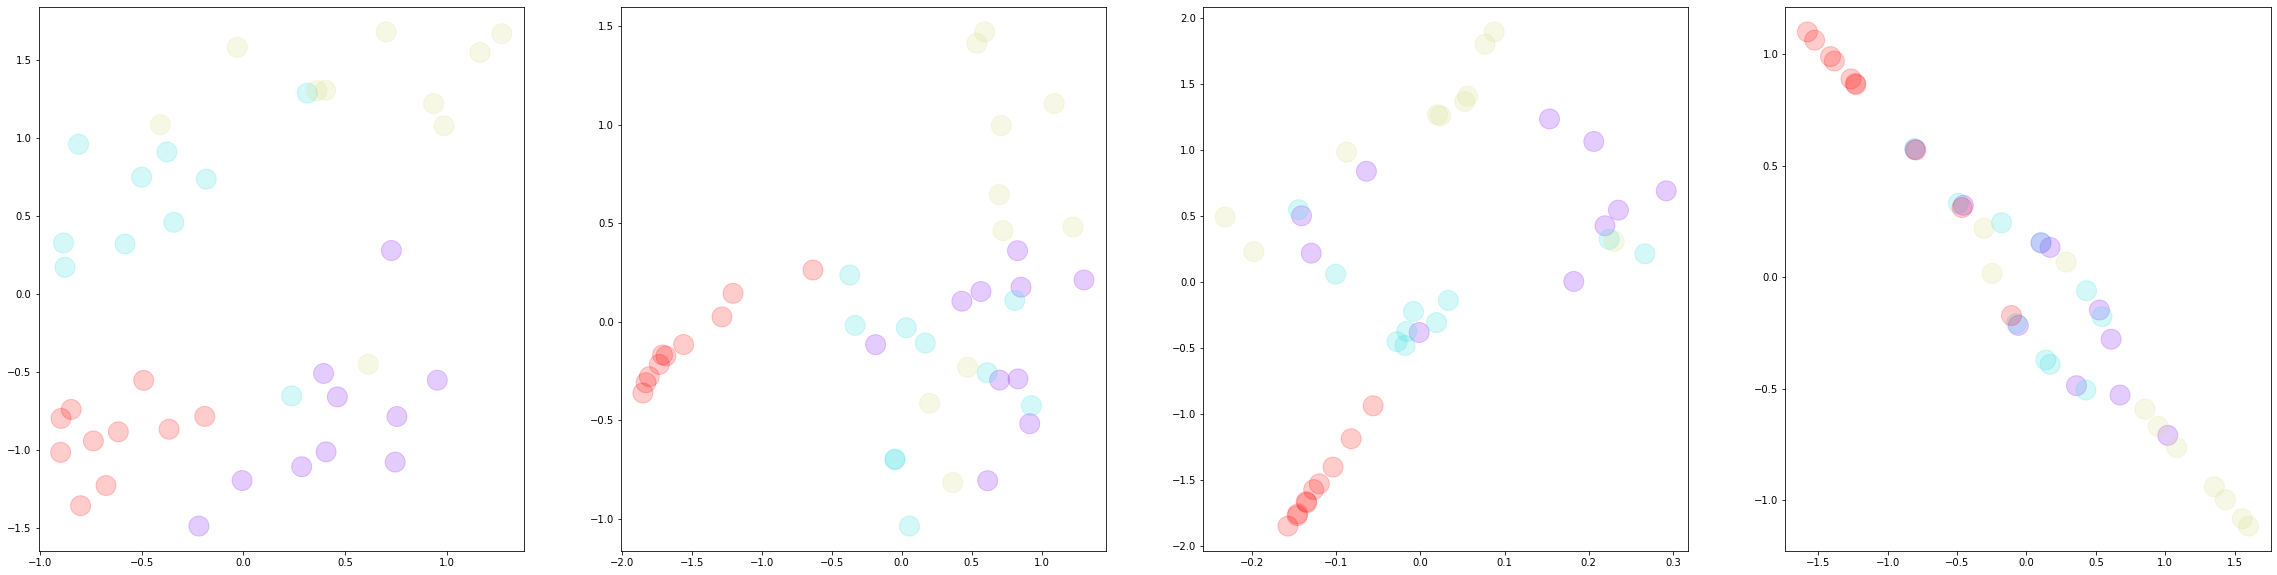

In [21]:
plt.figure(figsize=(40,10))

classnames, indices = np.unique(labels, return_inverse=True)
N = len(classnames)
cmap = plt.cm.rainbow
bounds = np.linspace(0,N,N+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.subplot(141)
embedding = h1
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400)

plt.subplot(142)
embedding = h2
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400)
plt.subplot(143)
embedding = h3
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400)
plt.subplot(144)
embedding = h4
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400)

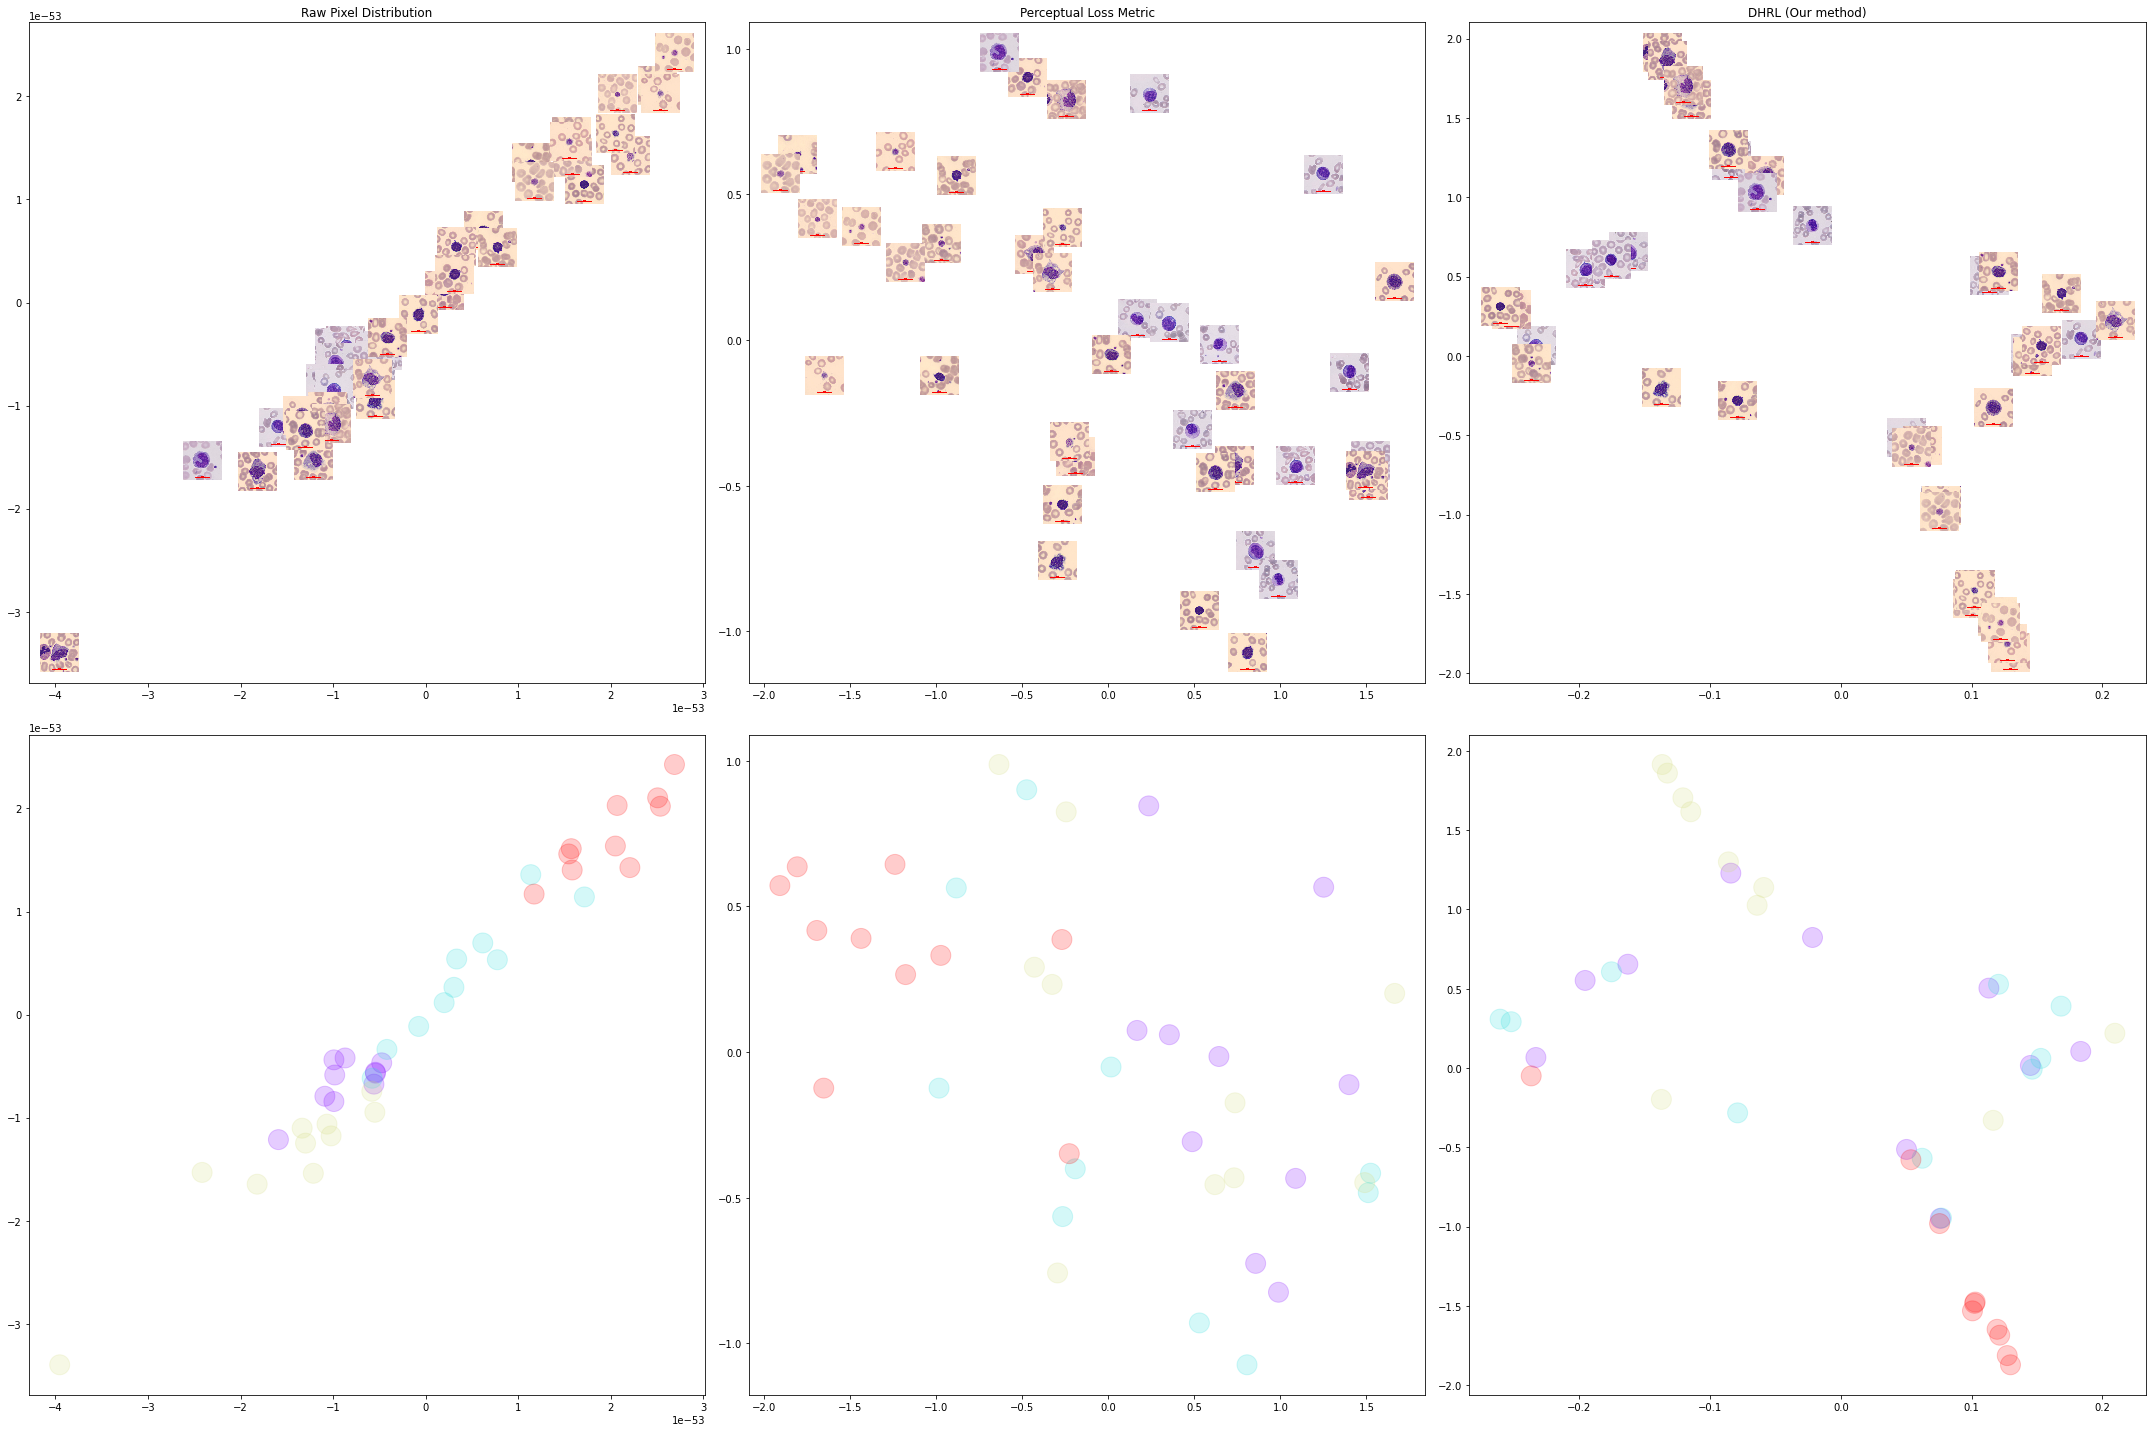

In [22]:
plt.figure(figsize=(30,20))
plt.subplot(231)
plt.title('Raw Pixel Distribution')
embedding = raw_image_embedding
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.15);
plt.subplot(234)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400, rasterized=True)
plt.subplot(232)
plt.title('Perceptual Loss Metric')
embedding = perceptual_embedding 
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.15);
plt.subplot(235)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400, rasterized=True)
plt.subplot(233)
plt.title('DHRL (Our method)')
embedding = vision_engine_embedding
imscatter(embedding[:, 0], embedding[:, 1], images, zoom=0.15);
plt.subplot(236)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.2,
        c=indices, cmap=cmap, norm=norm, s=400, rasterized=True)
plt.tight_layout()
fig = plt.gcf()

**Measure Disentanglement and Completeness Score**

In [23]:
with tf.device(f'/device:GPU:{GPU}'):
    labels = np.hstack([image[1] for image in data_loader.get_test_data()])
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(labels)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    inputs = onehot_encoded

In [24]:
h = 3
disent_w_avg, complete_avg = dissentanglement_score(z, inputs, h)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.382e-02, tolerance: 7.500e-04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.535e-01, tolerance: 7.500e-04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

In [25]:
print(disent_w_avg, complete_avg)

0.41867868089796645 0.2873125523328781
